# Data Exploration
This notebook explores the dataset we'll be using for Study 2, where we examine how VLM captions suffer when images are degraded.

## Setup

In [2]:
# Libraries
import json
import csv
import pandas as pd
import os
import re
import copy

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def generate_target_dataset(caption_dataset_filename, image_quality_dataset_filename):
    """
    Generates a target dataset for captioning based on VizWiz's image captioning dataset and image quality assessment dataset.

    Inputs:
    - caption_dataset_filename (str): path to caption dataset.
    - image_quality_dataset_filename (str): path to image quality dataset.

    Output:
    - (pd.DataFrame): dataframe containing image annotations and image quality.
    """
    # get images and annotations in one dataframe
    image_annotation_df = None
    with open(caption_dataset_filename) as f:
        # load caption dataset
        caption_dataset_json = json.load(f)

        # combine image files and annotations
        images_df = pd.DataFrame.from_dict(caption_dataset_json["images"])
        annotations_df = pd.DataFrame.from_dict(caption_dataset_json["annotations"])
        grouped_annotations = (
            annotations_df.groupby(["image_id"]).agg(tuple).map(list).reset_index()
        )
        image_annotation_df = images_df.merge(
            grouped_annotations[["image_id", "caption", "is_precanned", "is_rejected"]],
            left_on="id",
            right_on="image_id",
        )

        # vizwiz_url is broken, so fix with https://vizwiz.cs.colorado.edu/*
        image_annotation_df["vizwiz_url"] = image_annotation_df["vizwiz_url"].apply(
            lambda x: x.replace(
                "https://ivc.ischool.utexas.edu/", "https://vizwiz.cs.colorado.edu/"
            )
        )
    print(f"Caption Dataset size: {len(image_annotation_df)}")

    # get image quality
    with open(image_quality_dataset_filename) as f:
        # load image quality annotation dataset
        image_quality_dataset_json = json.load(f)
        image_quality_df = pd.DataFrame.from_dict(image_quality_dataset_json)

        # expand object of flaws into individual columns and rename
        image_quality_df = pd.concat(
            [
                image_quality_df.drop(["flaws"], axis=1),
                pd.json_normalize(image_quality_df["flaws"]),
            ],
            axis=1,
        )
        image_quality_df.rename(
            columns={
                "FRM": "framing",
                "BLR": "blur",
                "DRK": "too dark",
                "BRT": "too bright",
                "OBS": "obstruction",
                "OTH": "other",
                "NON": "no issue",
                "ROT": "rotation",
                "caption": "human_captions",
            },
            inplace=True,
        )

    print(f"Image Quality Dataset size: {len(image_quality_df)}")

    # combine image and quality datasets together
    image_captioning_input = image_annotation_df.merge(
        image_quality_df, left_on="file_name", right_on="image"
    ).drop(["image"], axis=1)

    # convert image_captioning_input to a list of dictionaries
    image_captioning_input = image_captioning_input.to_dict(orient="records")
    return image_captioning_input

In [4]:
def calculate_quality_metrics(df, reference_df=None, quality_columns=None):
    """
    Calculate quality issue counts and optionally percentages compared to a reference dataset.

    Args:
        df: DataFrame containing the quality issues data
        reference_df: Optional reference DataFrame to calculate percentages against
        quality_columns: List of quality issue column names. If None, uses default columns

    Returns:
        DataFrame with quality counts, and optionally percentages if reference_df is provided
    """
    if quality_columns is None:
        quality_columns = [
            "unrecognizable",
            "blur",
            "framing",
            "obstruction",
            "rotation",
            "too dark",
            "too bright",
            "other",
            "no issue",
        ]

    # Calculate counts
    quality_counts = pd.concat(
        [df[col].value_counts() for col in quality_columns], axis=1
    )
    quality_counts.columns = quality_columns

    # Replace NaN with 0 and convert to int
    quality_counts = quality_counts.fillna(0).astype(int)

    # sort index from 0 to 5
    quality_counts = quality_counts.sort_index()

    # Add total row
    quality_counts.loc["total"] = quality_counts.sum()

    # Calculate percentages if reference DataFrame is provided
    if reference_df is not None:
        reference_counts = calculate_quality_metrics(
            reference_df, quality_columns=quality_columns
        )
        quality_percentages = quality_counts.div(reference_counts, axis=0) * 100
        return quality_percentages.round(2)

    return quality_counts


def combine_counts_and_percentages(counts_df, percentages_df=None):
    """
    Combines counts and percentages into a single DataFrame with formatted strings.

    Args:
        counts_df: DataFrame containing the counts
        percentages_df: Optional DataFrame containing percentages. If None, percentages
                       will be calculated using the total row of counts_df

    Returns:
        DataFrame with formatted strings combining counts and percentages
    """
    # Calculate percentages if not provided
    if percentages_df is None:
        percentages_df = (counts_df.div(counts_df.loc["total"], axis=1) * 100).round(2)

    def format_count_and_percentage(count, percentage):
        count_str = (
            str(int(float(count))) if float(count).is_integer() else str(float(count))
        )
        return f"{count_str} ({percentage:.2f}%)"

    # Create combined DataFrame
    combined_stats = pd.DataFrame(
        [
            [
                format_count_and_percentage(count, pct)
                for count, pct in zip(row_counts, row_pcts)
            ]
            for row_counts, row_pcts in zip(counts_df.values, percentages_df.values)
        ],
        index=counts_df.index,
        columns=counts_df.columns,
    )

    return combined_stats

## Load Data
We start with loading the full data and printing some summary statistics of it.

In [5]:
original_dataset = generate_target_dataset(
    "../data/caption-dataset/annotations/train.json",
    "../data/image-quality-assessment/annotations/train.json",
)
original_dataset_df = pd.DataFrame(original_dataset)
original_dataset_df.head()

Caption Dataset size: 23431
Image Quality Dataset size: 23431


,file_name,vizwiz_url,id,text_detected,image_id,caption,is_precanned,is_rejected,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation
0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,0,True,0,[ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS ...,"[False, False, True, False, False]","[False, False, True, False, False]",1,3,1,0,0,0,1,1,0
1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,1,True,1,[A can of Coca Cola on a counter is shown for ...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,5,0,0,0,0,0,0
2,VizWiz_train_00000002.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,2,True,2,[A can of crushed tomatoes are on a brown surf...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,0,0,0,0,0,5,0
3,VizWiz_train_00000003.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,3,True,3,[A white screen with a captcha that needs to b...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,0,0,0,0,0,5,0
4,VizWiz_train_00000004.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,4,True,4,[A box for a garden light rests in someone's l...,"[False, False, False, False, False]","[False, False, False, False, False]",0,3,0,0,0,0,0,2,0


### Summary of Data Counts

In [6]:
# total data size
print(f"Total data size: {len(original_dataset_df)}")

Total data size: 23431


In [7]:
quality_counts_full = calculate_quality_metrics(original_dataset_df)
quality_counts_full

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,15751,9248,5718,20163,16732,19100,19280,21558,6385
1,4122,4631,4779,2428,2713,2964,2903,1687,5705
2,1424,2856,4655,451,1547,704,721,145,3976
3,878,2452,4187,182,1353,298,295,28,2952
4,725,2341,2935,148,818,236,163,13,2519
5,531,1903,1157,59,268,129,69,0,1894
total,23431,23431,23431,23431,23431,23431,23431,23431,23431


### Co-Occurrence Matrix
For each pair of issues, show the co-occurence between issues.

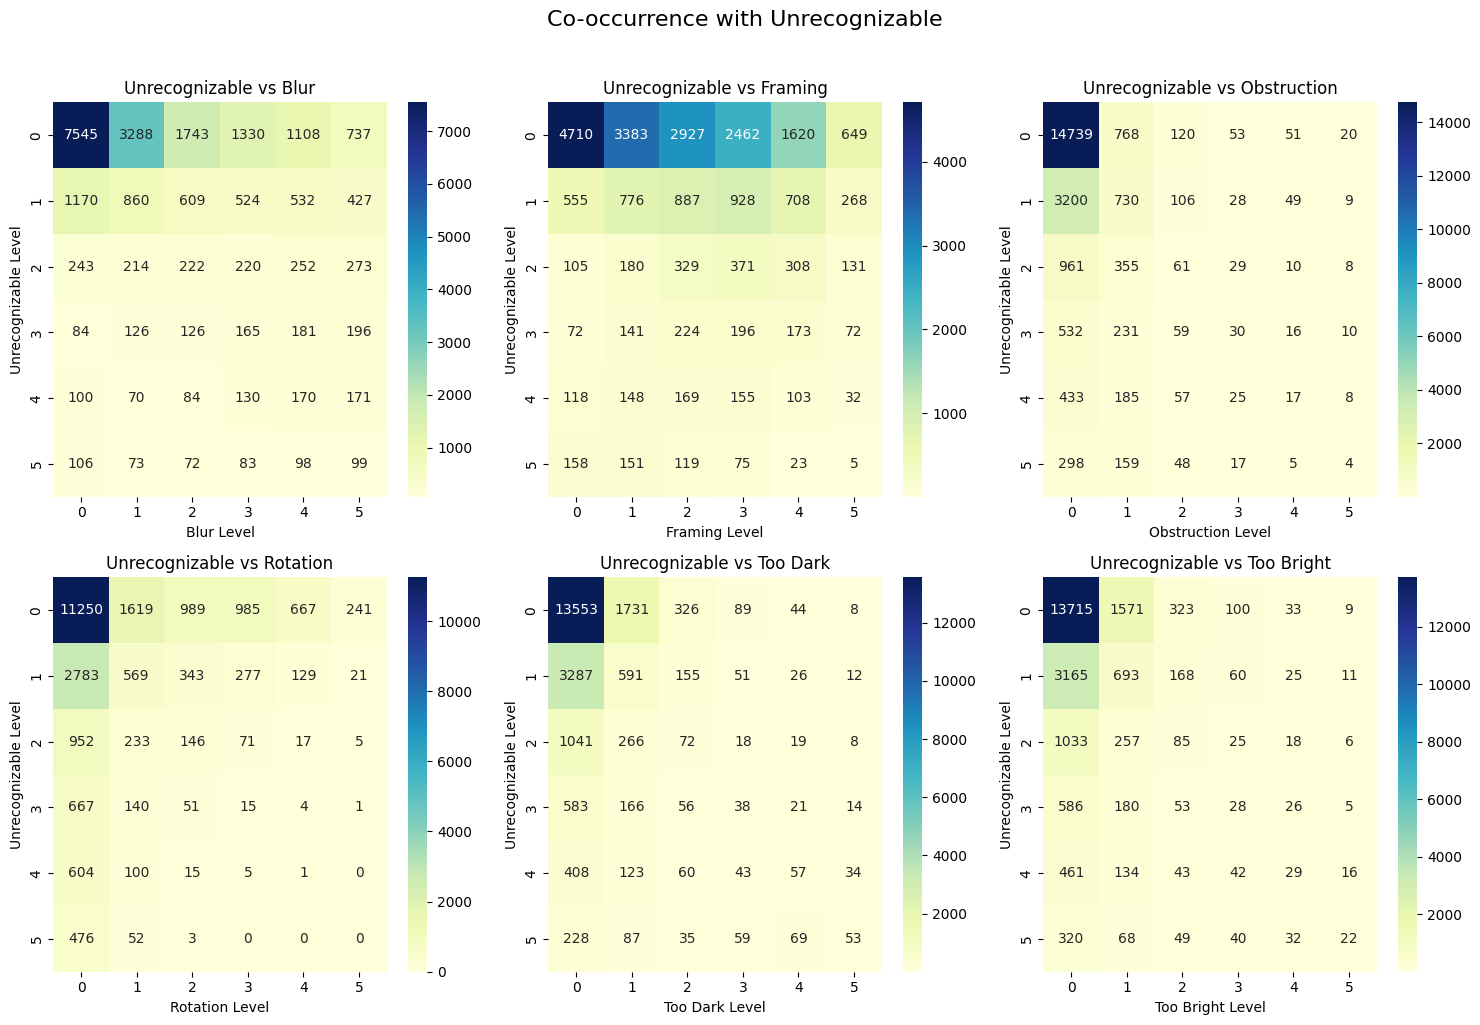

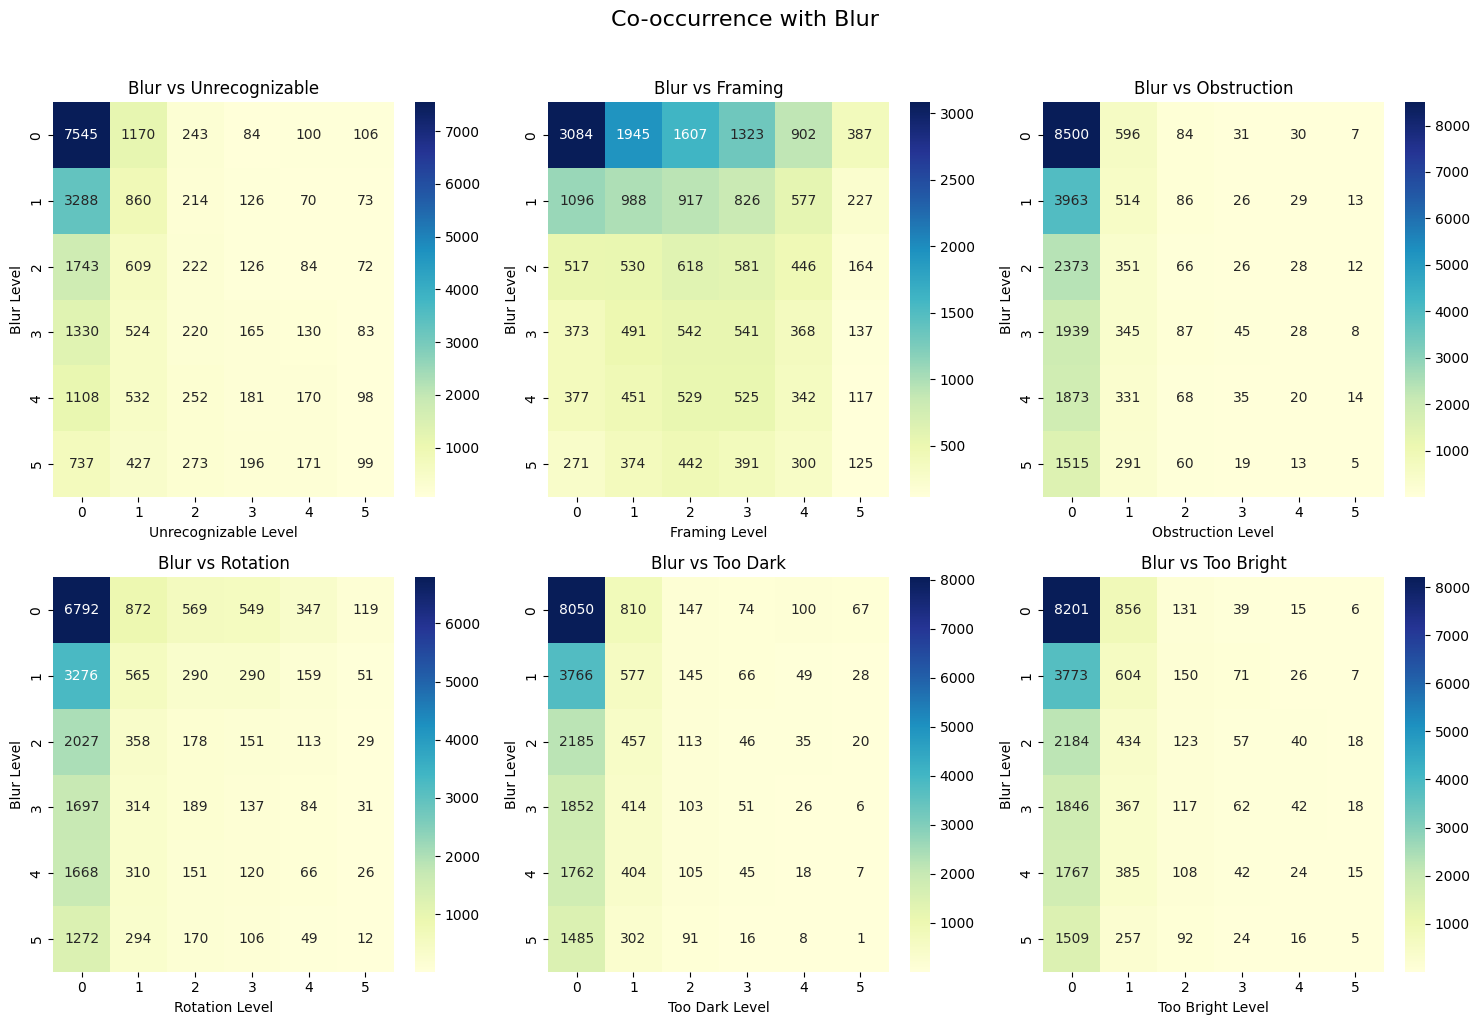

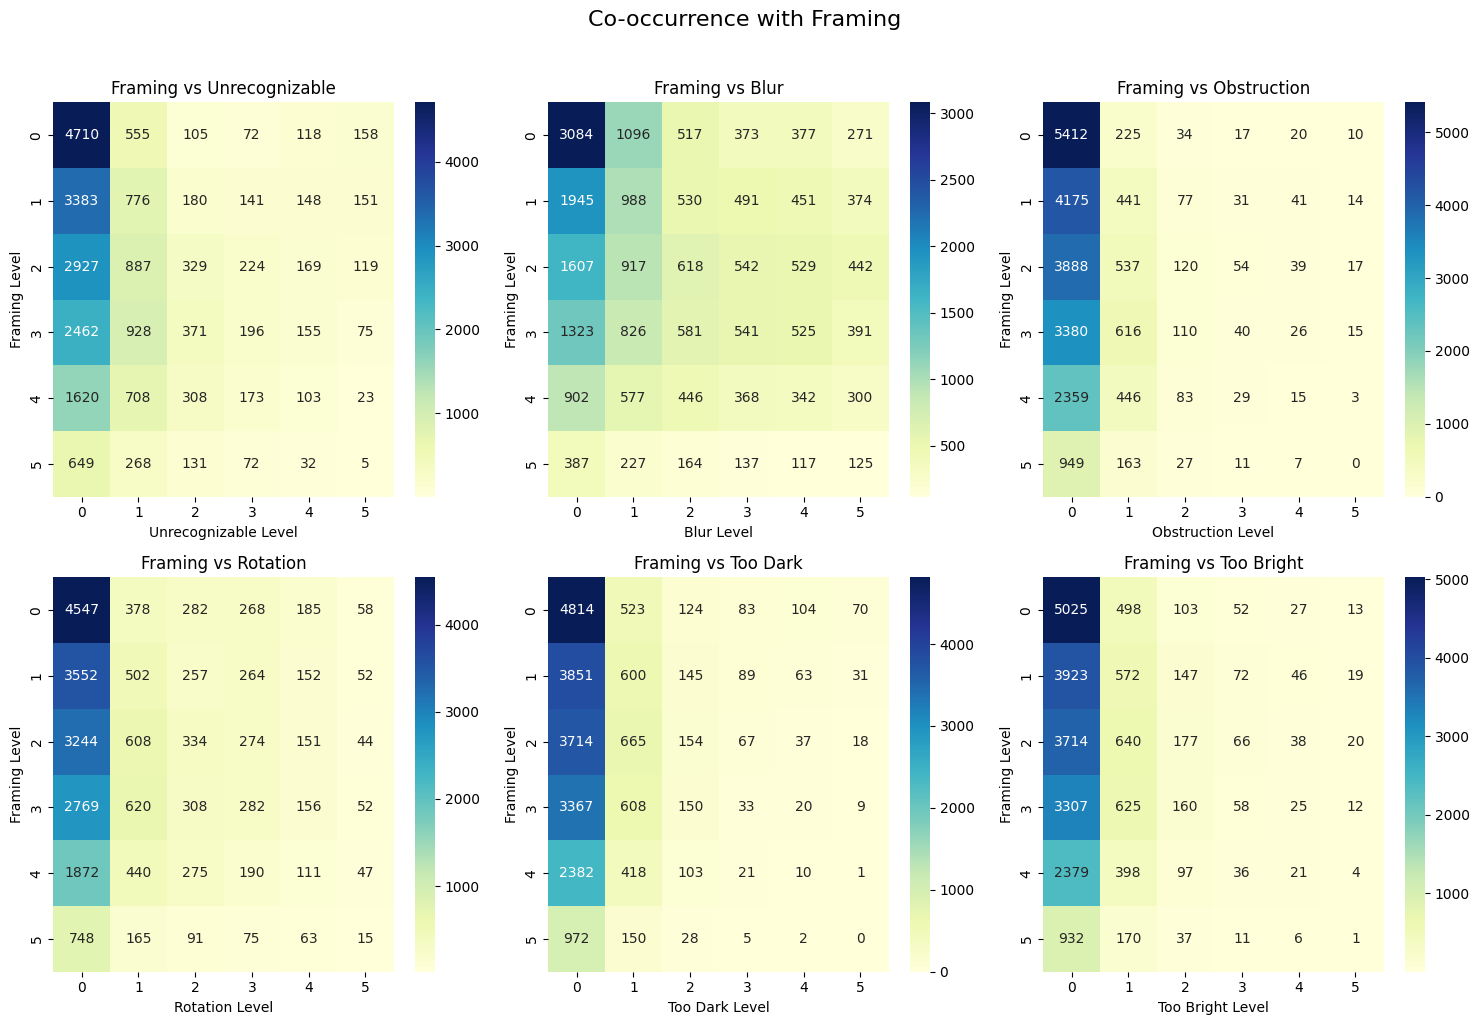

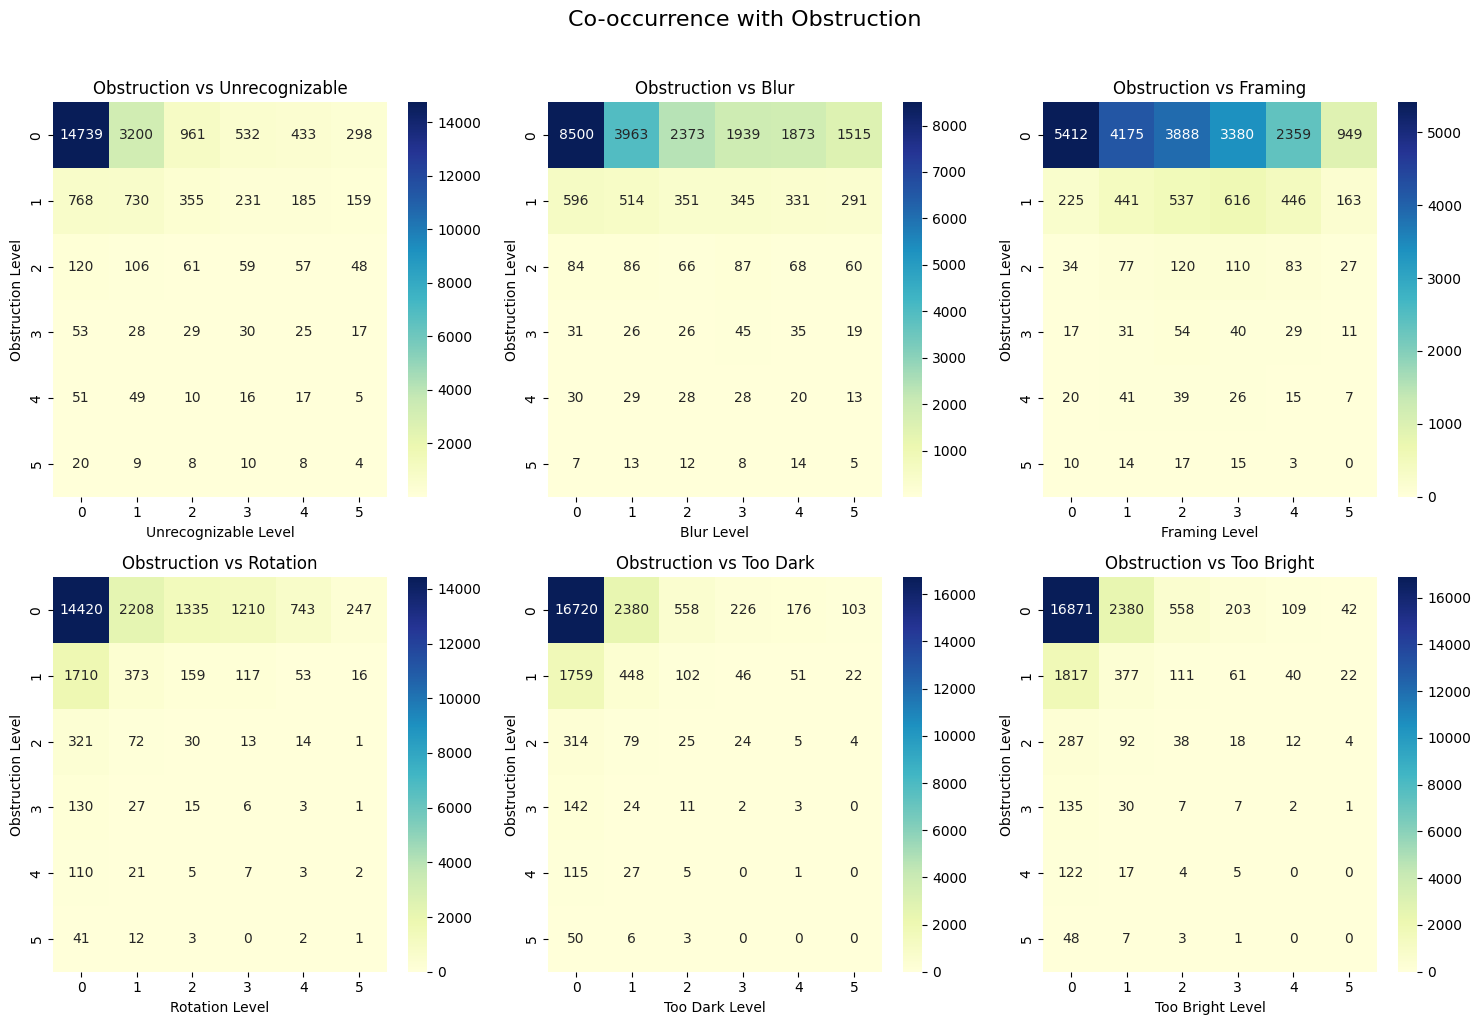

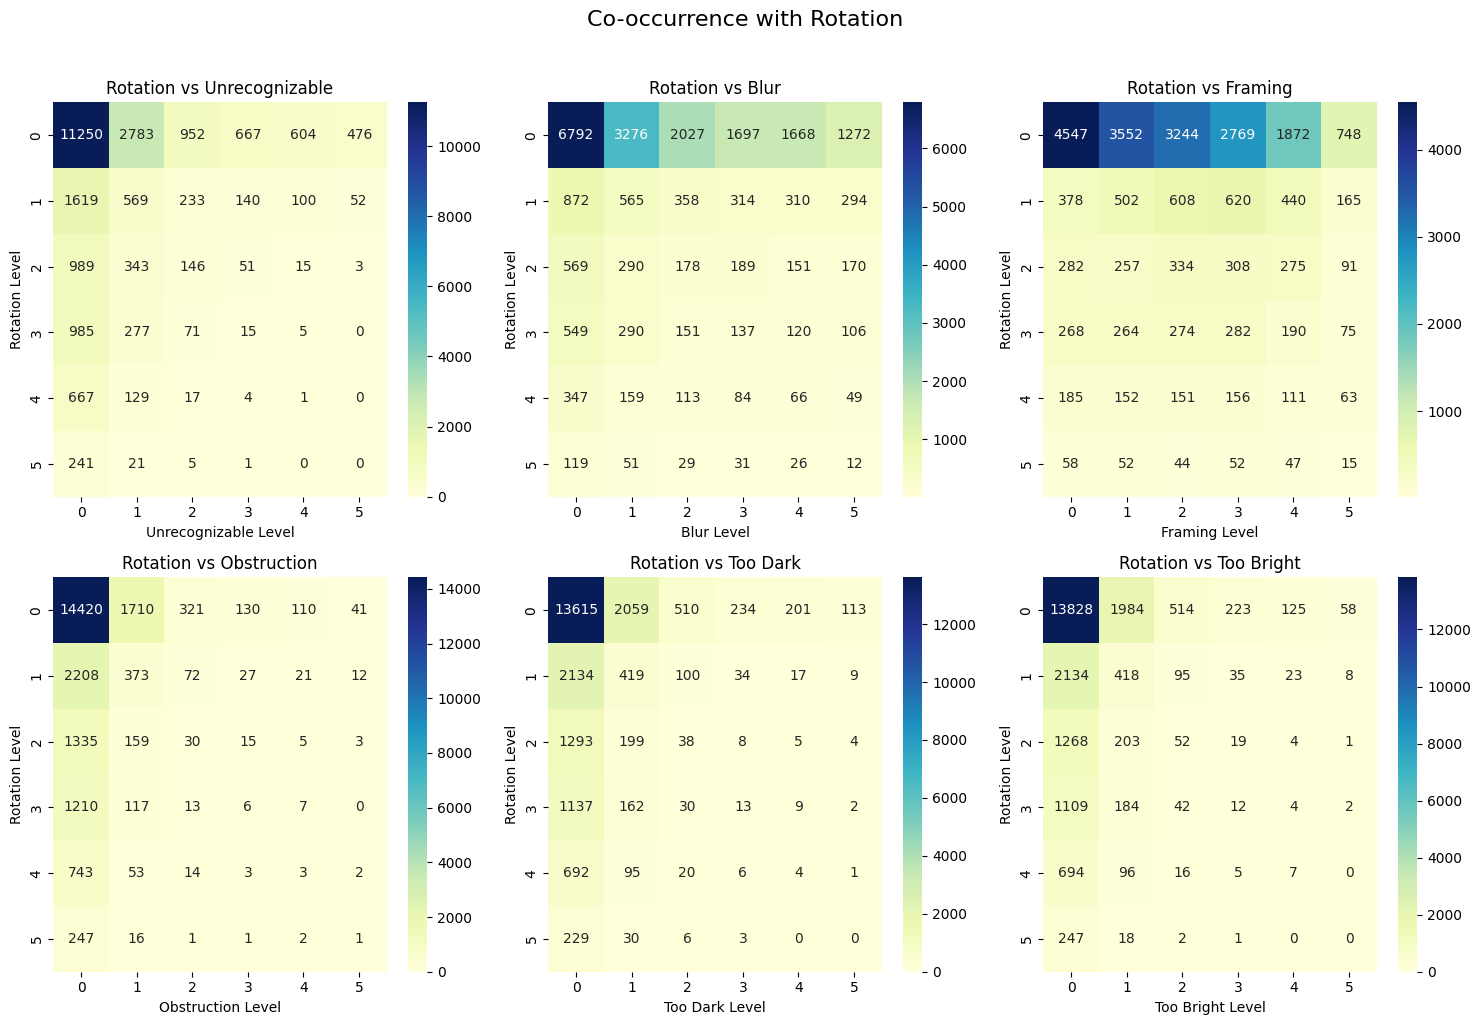

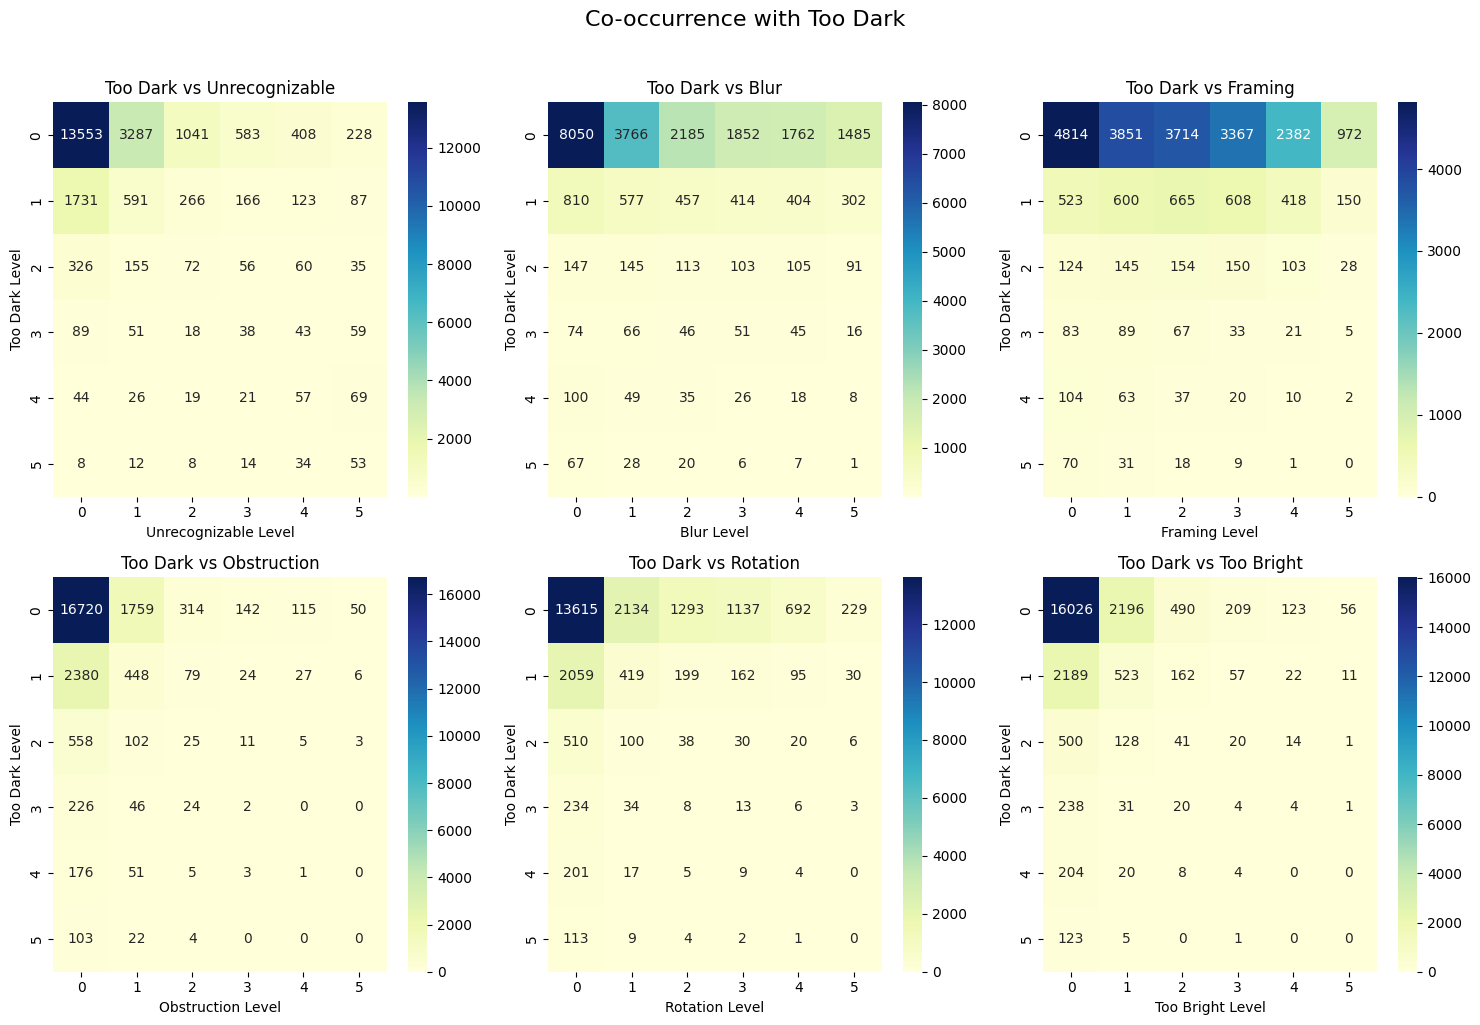

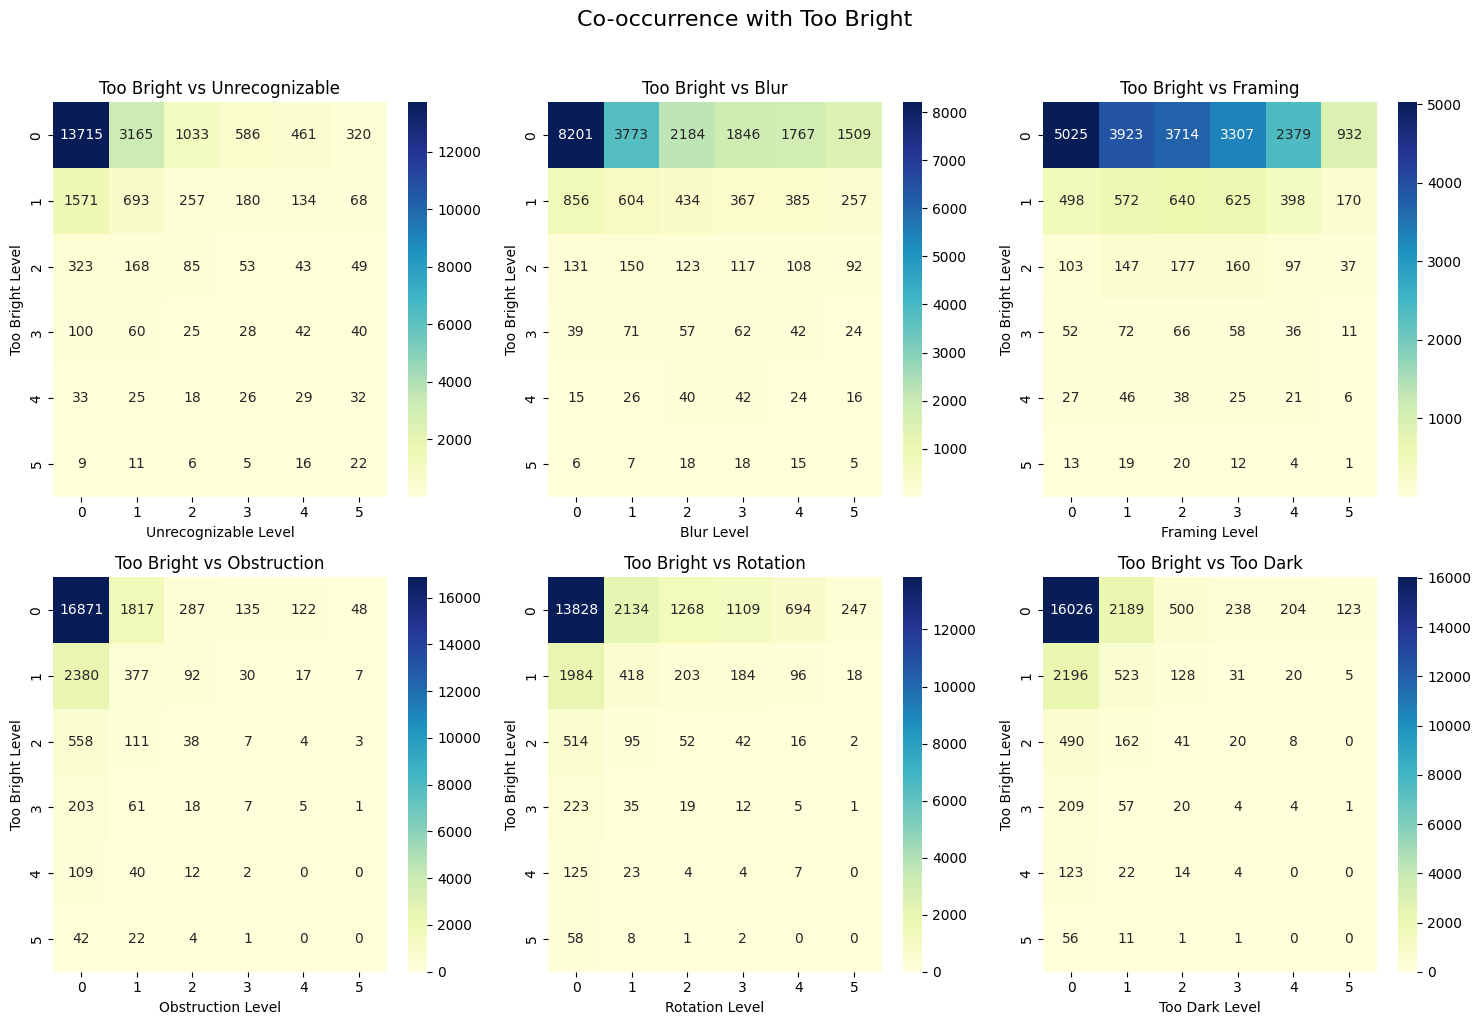

In [8]:
# Create faceted plots for each primary issue
quality_issues = [
    "unrecognizable",
    "blur",
    "framing",
    "obstruction",
    "rotation",
    "too dark",
    "too bright",
]

for primary_issue in quality_issues:
    # Calculate number of other issues to compare against (excluding the primary issue)
    other_issues = [issue for issue in quality_issues if issue != primary_issue]
    n_comparisons = len(other_issues)

    # Calculate grid dimensions - we want roughly square layout
    n_cols = 3  # you can adjust this for different layouts
    n_rows = (n_comparisons + n_cols - 1) // n_cols

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle(f"Co-occurrence with {primary_issue.title()}", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if n_rows > 1 else [axes]

    # Create heatmaps
    for idx, secondary_issue in enumerate(other_issues):
        if idx < len(axes_flat):
            ax = axes_flat[idx]

            # Create co-occurrence matrix
            cooccurrence = pd.crosstab(
                original_dataset_df[primary_issue], original_dataset_df[secondary_issue]
            )

            # Create heatmap
            sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
            ax.set_xlabel(f"{secondary_issue.title()} Level")
            ax.set_ylabel(f"{primary_issue.title()} Level")
            ax.set_title(f"{primary_issue.title()} vs {secondary_issue.title()}")

    # Remove empty subplots if any
    for idx in range(len(other_issues), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()

# Dataset: images with image quality issues

## Step 1: Data Selection

We begin by creating two subsets of the data:

1. `Subset-Easy` that capture images where humans can confidently provide a caption, indicating that image quality issues are not severe enough to prevent captioning. We select this data by selecting images where votes for unrecognizable were `< 3` (i.e., at least three people could provide a caption).

2. `Subset-Hard` that capture images where humans are not confident providing a caption. This can be due to severe image quality issues (e.g., too blurry to read a label) or lack of knowledge about a product (e.g., unfamiliar with American breakfast cereals). We selected this data by selecting images where the votes for unrecognizable were `>= 3` (i.e., at least three people could not provide a caption).

In [9]:
# Subset-Easy
subset_easy_df = original_dataset_df[original_dataset_df["unrecognizable"] < 3]
print(f"Size of Subset-Easy: {len(subset_easy_df)}")
print(
    f"Percentage of original dataset: {100 * len(subset_easy_df) / len(original_dataset_df):.2f}%"
)

Size of Subset-Easy: 21297
Percentage of original dataset: 90.89%


In [10]:
quality_counts_subset_easy = calculate_quality_metrics(subset_easy_df)
quality_counts_subset_easy

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,15751,8958,5370,18900,14985,17881,17913,20051,4866
1,4122,4362,4339,1853,2421,2588,2521,1197,5217
2,1424,2574,4143,287,1478,553,576,47,3871
3,0,2074,3761,110,1333,158,185,2,2932
4,0,1892,2636,110,813,89,76,0,2518
5,0,1437,1048,37,267,28,26,0,1893
total,21297,21297,21297,21297,21297,21297,21297,21297,21297


In [11]:
quality_counts_subset_easy_vs_full = calculate_quality_metrics(
    subset_easy_df, reference_df=original_dataset_df
)
quality_counts_subset_easy_vs_full

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,100.00,96.86,93.91,93.74,89.56,93.62,92.91,93.01,76.21
1,100.00,94.19,90.79,76.32,89.24,87.31,86.84,70.95,91.45
2,100.00,90.13,89.00,63.64,95.54,78.55,79.89,32.41,97.36
3,0.00,84.58,89.83,60.44,98.52,53.02,62.71,7.14,99.32
4,0.00,80.82,89.81,74.32,99.39,37.71,46.63,0.00,99.96
5,0.00,75.51,90.58,62.71,99.63,21.71,37.68,NaN,99.95
total,90.89,90.89,90.89,90.89,90.89,90.89,90.89,90.89,90.89


In [12]:
# Subset-Hard
subset_hard_df = original_dataset_df[original_dataset_df["unrecognizable"] >= 3]
print(f"Size of Subset-Hard: {len(subset_hard_df)}")
print(
    f"Percentage of original dataset: {100 * len(subset_hard_df) / len(original_dataset_df):.2f}%"
)

Size of Subset-Hard: 2134
Percentage of original dataset: 9.11%


In [13]:
quality_counts_subset_hard = calculate_quality_metrics(subset_hard_df)
quality_counts_subset_hard

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,0,290,348,1263,1747,1219,1367,1507,1519
1,0,269,440,575,292,376,382,490,488
2,0,282,512,164,69,151,145,98,105
3,878,378,426,72,20,140,110,26,20
4,725,449,299,38,5,147,87,13,1
5,531,466,109,22,1,101,43,0,1
total,2134,2134,2134,2134,2134,2134,2134,2134,2134


In [14]:
quality_counts_subset_hard_vs_full = calculate_quality_metrics(
    subset_hard_df, reference_df=original_dataset_df
)
quality_counts_subset_hard_vs_full

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,0.00,3.14,6.09,6.26,10.44,6.38,7.09,6.99,23.79
1,0.00,5.81,9.21,23.68,10.76,12.69,13.16,29.05,8.55
2,0.00,9.87,11.00,36.36,4.46,21.45,20.11,67.59,2.64
3,100.00,15.42,10.17,39.56,1.48,46.98,37.29,92.86,0.68
4,100.00,19.18,10.19,25.68,0.61,62.29,53.37,100.00,0.04
5,100.00,24.49,9.42,37.29,0.37,78.29,62.32,NaN,0.05
total,9.11,9.11,9.11,9.11,9.11,9.11,9.11,9.11,9.11


## Step 2: Filter on Image Quality Issues
We now take the above data subsets and filter for image quality issues. We focus on 4 issues:
1. Blur
2. Framing
3. Obstruction
4. Rotation

We explore 2 inclusion criteria:
1. `>=4` human captioners voted for any of the above issues
2. `>=3` human captioners voted for any of the above issues

In [15]:
# setup which issues to filter on
issues_to_filter = [
    "blur",
    "framing",
    "obstruction",
    "rotation",
    "too dark",
    "too bright",
]

### Case: >=4 voters

In [16]:
# include issues if >=4 human captioners voted for it
subset_easy_filtered4_df = subset_easy_df[
    (subset_easy_df[issues_to_filter] >= 4).any(axis=1)
]

# Print the number of rows in subset_easy_filtered4_df
print(f"Number of rows in subset_easy_filtered4_df: {len(subset_easy_filtered4_df)}")

# Calculate the percentage of subset_easy that was filtered
print(
    f"Percentage of subset_easy that meets the filtering criteria: {(len(subset_easy_filtered4_df) / len(subset_easy_df)) * 100:.2f}%"
)
print(
    f"Percentage of original dataset that meets the filtering criteria: {(len(subset_easy_filtered4_df) / len(original_dataset_df)) * 100:.2f}%"
)

Number of rows in subset_easy_filtered4_df: 7304
Percentage of subset_easy that meets the filtering criteria: 34.30%
Percentage of original dataset that meets the filtering criteria: 31.17%


In [17]:
subset_easy_filtered4_df_quality_counts = calculate_quality_metrics(
    subset_easy_filtered4_df, quality_columns=["unrecognizable"] + issues_to_filter
)
subset_easy_filtered4_df_quality_counts

combine_counts_and_percentages(subset_easy_filtered4_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,4553 (62.34%),1699 (23.26%),839 (11.49%),6150 (84.20%),4324 (59.20%),5881 (80.52%),5993 (82.05%)
1,1888 (25.85%),979 (13.40%),894 (12.24%),835 (11.43%),898 (12.29%),1020 (13.96%),922 (12.62%)
2,863 (11.82%),734 (10.05%),968 (13.25%),130 (1.78%),556 (7.61%),233 (3.19%),230 (3.15%)
3,0 (0.00%),563 (7.71%),919 (12.58%),42 (0.58%),446 (6.11%),53 (0.73%),57 (0.78%)
4,0 (0.00%),1892 (25.90%),2636 (36.09%),110 (1.51%),813 (11.13%),89 (1.22%),76 (1.04%)
5,0 (0.00%),1437 (19.67%),1048 (14.35%),37 (0.51%),267 (3.66%),28 (0.38%),26 (0.36%)
total,7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%)


In [18]:
# include issues if >=4 human captioners voted for it
subset_hard_filtered4_df = subset_hard_df[
    (subset_hard_df[issues_to_filter] >= 4).any(axis=1)
]
# Print the number of rows in subset_hard_filtered4_df
print(f"Number of rows in subset_hard_filtered4_df: {len(subset_hard_filtered4_df)}")

# Calculate the percentage of subset_hard that was filtered
print(
    f"Percentage of subset_hard that meets the filtering criteria: {(len(subset_hard_filtered4_df) / len(subset_hard_df)) * 100:.2f}%"
)
print(
    f"Percentage of original dataset that meets the filtering criteria: {(len(subset_hard_filtered4_df) / len(original_dataset_df)) * 100:.2f}%"
)

Number of rows in subset_hard_filtered4_df: 1478
Percentage of subset_hard that meets the filtering criteria: 69.26%
Percentage of original dataset that meets the filtering criteria: 6.31%


In [19]:
subset_hard_filtered4_df_quality_counts = calculate_quality_metrics(
    subset_hard_filtered4_df, quality_columns=["unrecognizable"] + issues_to_filter
)
combine_counts_and_percentages(subset_hard_filtered4_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,0 (0.00%),176 (11.91%),249 (16.85%),887 (60.01%),1171 (79.23%),862 (58.32%),952 (64.41%)
1,0 (0.00%),127 (8.59%),285 (19.28%),385 (26.05%),228 (15.43%),245 (16.58%),254 (17.19%)
2,0 (0.00%),120 (8.12%),290 (19.62%),100 (6.77%),54 (3.65%),86 (5.82%),88 (5.95%)
3,587 (39.72%),140 (9.47%),246 (16.64%),46 (3.11%),19 (1.29%),37 (2.50%),54 (3.65%)
4,521 (35.25%),449 (30.38%),299 (20.23%),38 (2.57%),5 (0.34%),147 (9.95%),87 (5.89%)
5,370 (25.03%),466 (31.53%),109 (7.37%),22 (1.49%),1 (0.07%),101 (6.83%),43 (2.91%)
total,1478 (100.00%),1478 (100.00%),1478 (100.00%),1478 (100.00%),1478 (100.00%),1478 (100.00%),1478 (100.00%)


### Case: >= 3

In [20]:
# include issues if >=3 human captioners voted for it
subset_easy_filtered3_df = subset_easy_df[
    (subset_easy_df[issues_to_filter] >= 3).any(axis=1)
]

# Print the number of rows in subset_easy_filtered3_df
print(f"Number of rows in subset_easy_filtered3_df: {len(subset_easy_filtered3_df)}")

# Calculate the percentage of subset_easy that was filtered
print(
    f"Percentage of subset_easy that meets the filtering criteria: {(len(subset_easy_filtered3_df) / len(subset_easy_df)) * 100:.2f}%"
)
print(
    f"Percentage of original dataset that meets the filtering criteria: {(len(subset_easy_filtered3_df) / len(original_dataset_df)) * 100:.2f}%"
)

Number of rows in subset_easy_filtered3_df: 12019
Percentage of subset_easy that meets the filtering criteria: 56.44%
Percentage of original dataset that meets the filtering criteria: 51.30%


In [21]:
subset_easy_filtered3_df_quality_counts = calculate_quality_metrics(
    subset_easy_filtered3_df, quality_columns=["unrecognizable"] + issues_to_filter
)
subset_easy_filtered3_df_quality_counts

combine_counts_and_percentages(subset_easy_filtered3_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,7922 (65.91%),3316 (27.59%),1425 (11.86%),10203 (84.89%),7273 (60.51%),9716 (80.84%),9773 (81.31%)
1,2911 (24.22%),1955 (16.27%),1524 (12.68%),1348 (11.22%),1462 (12.16%),1666 (13.86%),1571 (13.07%)
2,1186 (9.87%),1345 (11.19%),1625 (13.52%),211 (1.76%),871 (7.25%),362 (3.01%),388 (3.23%)
3,0 (0.00%),2074 (17.26%),3761 (31.29%),110 (0.92%),1333 (11.09%),158 (1.31%),185 (1.54%)
4,0 (0.00%),1892 (15.74%),2636 (21.93%),110 (0.92%),813 (6.76%),89 (0.74%),76 (0.63%)
5,0 (0.00%),1437 (11.96%),1048 (8.72%),37 (0.31%),267 (2.22%),28 (0.23%),26 (0.22%)
total,12019 (100.00%),12019 (100.00%),12019 (100.00%),12019 (100.00%),12019 (100.00%),12019 (100.00%),12019 (100.00%)


In [22]:
# include issues if >=3 human captioners voted for it
subset_hard_filtered3_df = subset_hard_df[
    (subset_hard_df[issues_to_filter] >= 3).any(axis=1)
]
# Print the number of rows in subset_hard_filtered3_df
print(f"Number of rows in subset_hard_filtered3_df: {len(subset_hard_filtered3_df)}")

# Calculate the percentage of subset_hard that was filtered
print(
    f"Percentage of subset_hard that meets the filtering criteria: {(len(subset_hard_filtered3_df) / len(subset_hard_df)) * 100:.2f}%"
)
print(
    f"Percentage of original dataset that meets the filtering criteria: {(len(subset_hard_filtered3_df) / len(original_dataset_df)) * 100:.2f}%"
)

Number of rows in subset_hard_filtered3_df: 1930
Percentage of subset_hard that meets the filtering criteria: 90.44%
Percentage of original dataset that meets the filtering criteria: 8.24%


In [23]:
subset_hard_filtered3_df_quality_counts = calculate_quality_metrics(
    subset_hard_filtered3_df, quality_columns=["unrecognizable"] + issues_to_filter
)
combine_counts_and_percentages(subset_hard_filtered3_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,0 (0.00%),240 (12.44%),315 (16.32%),1131 (58.60%),1562 (80.93%),1093 (56.63%),1239 (64.20%)
1,0 (0.00%),194 (10.05%),373 (19.33%),518 (26.84%),275 (14.25%),331 (17.15%),328 (16.99%)
2,0 (0.00%),203 (10.52%),408 (21.14%),149 (7.72%),67 (3.47%),118 (6.11%),123 (6.37%)
3,779 (40.36%),378 (19.59%),426 (22.07%),72 (3.73%),20 (1.04%),140 (7.25%),110 (5.70%)
4,660 (34.20%),449 (23.26%),299 (15.49%),38 (1.97%),5 (0.26%),147 (7.62%),87 (4.51%)
5,491 (25.44%),466 (24.15%),109 (5.65%),22 (1.14%),1 (0.05%),101 (5.23%),43 (2.23%)
total,1930 (100.00%),1930 (100.00%),1930 (100.00%),1930 (100.00%),1930 (100.00%),1930 (100.00%),1930 (100.00%)


## Step 3: Remove any images without text
Acts as a proxy for products.

In [24]:
subset_easy_filtered4_hastext_df = subset_easy_filtered4_df[
    subset_easy_filtered4_df["text_detected"] == True
]
subset_easy_filtered4_hastext_df.head()

,file_name,vizwiz_url,id,text_detected,image_id,caption,is_precanned,is_rejected,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation
1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,1,True,1,[A can of Coca Cola on a counter is shown for ...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,5,0,0,0,0,0,0
8,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,8,True,8,[candy with pink color to eat and enjoy and te...,"[False, False, False, False, False]","[False, False, False, False, False]",0,4,0,0,0,0,0,1,0
11,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,11,True,11,[imagine how you would describe this image on ...,"[False, False, False, False, False]","[True, False, False, False, False]",0,2,2,1,1,4,0,0,1
20,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,20,True,20,[A copy of Grand theft auto vice city for Play...,"[False, False, False, False, False]","[False, False, False, False, False]",0,4,0,0,0,1,0,0,0
26,VizWiz_train_00000026.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,26,True,26,[The photo is of a bottle of some sort of sl...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,4,0,0,0,0,1,0


In [25]:
subset_easy_filtered4_hastext_df_quality_counts = calculate_quality_metrics(
    subset_easy_filtered4_hastext_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
subset_easy_filtered4_hastext_df_quality_counts

combine_counts_and_percentages(subset_easy_filtered4_hastext_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,3713 (68.35%),1302 (23.97%),603 (11.10%),4732 (87.11%),3006 (55.34%),4492 (82.70%),4495 (82.75%)
1,1255 (23.10%),731 (13.46%),613 (11.28%),539 (9.92%),647 (11.91%),710 (13.07%),667 (12.28%)
2,464 (8.54%),517 (9.52%),700 (12.89%),64 (1.18%),458 (8.43%),157 (2.89%),163 (3.00%)
3,0 (0.00%),427 (7.86%),696 (12.81%),24 (0.44%),394 (7.25%),29 (0.53%),40 (0.74%)
4,0 (0.00%),1366 (25.15%),1948 (35.86%),50 (0.92%),699 (12.87%),32 (0.59%),47 (0.87%)
5,0 (0.00%),1089 (20.05%),872 (16.05%),23 (0.42%),228 (4.20%),12 (0.22%),20 (0.37%)
total,5432 (100.00%),5432 (100.00%),5432 (100.00%),5432 (100.00%),5432 (100.00%),5432 (100.00%),5432 (100.00%)


In [26]:
combine_counts_and_percentages(subset_easy_filtered4_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,4553 (62.34%),1699 (23.26%),839 (11.49%),6150 (84.20%),4324 (59.20%),5881 (80.52%),5993 (82.05%)
1,1888 (25.85%),979 (13.40%),894 (12.24%),835 (11.43%),898 (12.29%),1020 (13.96%),922 (12.62%)
2,863 (11.82%),734 (10.05%),968 (13.25%),130 (1.78%),556 (7.61%),233 (3.19%),230 (3.15%)
3,0 (0.00%),563 (7.71%),919 (12.58%),42 (0.58%),446 (6.11%),53 (0.73%),57 (0.78%)
4,0 (0.00%),1892 (25.90%),2636 (36.09%),110 (1.51%),813 (11.13%),89 (1.22%),76 (1.04%)
5,0 (0.00%),1437 (19.67%),1048 (14.35%),37 (0.51%),267 (3.66%),28 (0.38%),26 (0.36%)
total,7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%),7304 (100.00%)


# Dataset: Merging with Long-Form QA Dataset
In separate experiments, we've seen that short captions are harder to evaluate with our models. So, let's try to see if we can merge a subset of our data with data from [Long-Form Answers to Visual Questions from Blind and Low Vision People](https://minahuh.com/LFVQA/).

In [27]:
# get VQA data that the LFA dataset is based ond
with open("../data/vqa/train.json", "r") as f:
    vqa_data = json.load(f)

print(f"VQA dataset size: {len(vqa_data)}")

# remove answers from VQA dataset
vqa_data_df = pd.DataFrame([vqa_data[i] for i in range(len(vqa_data))])
vqa_data_df = vqa_data_df.drop(columns=["answers"])

# rename image to image_name
vqa_data_df = vqa_data_df.rename(columns={"image": "image_name"})

# strip the question column
vqa_data_df["question"] = vqa_data_df["question"].str.strip()
vqa_data_df.head()

VQA dataset size: 20523


,image_name,question,answer_type,answerable
0,VizWiz_train_00000000.jpg,What's the name of this product?,other,1
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,other,1
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,other,1
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,other,1
4,VizWiz_train_00000004.jpg,What is this item?,other,1


In [28]:
# get the long-form answers from json file
with open("../data/vqa/lfa_vqa.json", "r") as f:
    lfa_data = json.load(f)

print(f"Long-form VQA dataset size: {len(lfa_data.keys())}")

# format the datset for pandas
lfa_data_pandas_formatted = []
for key, value in lfa_data.items():
    lfa_data_pandas_formatted.append(
        {
            "image_index": key,
            "image_name": value["image_url"].replace(
                "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/", ""
            ),
            "vizwiz_url": value["image_url"],
            "question": value["question"].strip(),
            "question_type": value["question_type"],
            "expert_answer": value["long_answers"]["Expert"][
                "answer_paragraph"
            ].strip(),
        }
    )

lfa_data_df = pd.DataFrame(lfa_data_pandas_formatted)
lfa_data_df.head()

Long-form VQA dataset size: 600


,image_index,image_name,vizwiz_url,question,question_type,expert_answer
0,1,VizWiz_train_00014902.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,I'm trying to determine what this jar is. It l...,Identification,The picture of the jar is extremely zoomed in ...
1,2,VizWiz_train_00016783.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,Can you tell me what kind of vehicle this is?,Identification,This is a white pick-up truck from Mikels CONS...
2,3,VizWiz_train_00017658.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this box?,Identification,There is no box in the image. A glass with lio...
3,4,VizWiz_train_00013289.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this?,Identification,The image shows a chocolate milk carton by Sil...
4,5,VizWiz_train_00012786.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ..."


In [29]:
# merge the VQA and LFA datasets based on question column
vqa_lfa_df = pd.merge(
    vqa_data_df,
    lfa_data_df[
        ["image_name", "vizwiz_url", "question", "question_type", "expert_answer"]
    ],
    on="image_name",
    how="right",
)


print(f"VQA + LFA dataset size: {len(vqa_lfa_df)}")
vqa_lfa_df.head()

VQA + LFA dataset size: 600


,image_name,question_x,answer_type,answerable,vizwiz_url,question_y,question_type,expert_answer
0,VizWiz_train_00014902.jpg,I'm trying to determine what this jar is. It l...,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,I'm trying to determine what this jar is. It l...,Identification,The picture of the jar is extremely zoomed in ...
1,VizWiz_train_00016783.jpg,Can you tell me what kind of vehicle this is?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,Can you tell me what kind of vehicle this is?,Identification,This is a white pick-up truck from Mikels CONS...
2,VizWiz_train_00017658.jpg,What is this box?,unanswerable,0.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this box?,Identification,There is no box in the image. A glass with lio...
3,VizWiz_train_00013289.jpg,What is this?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this?,Identification,The image shows a chocolate milk carton by Sil...
4,VizWiz_train_00012786.jpg,What kind of chips are these?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ..."


## Merge with the full image quality dataset
Let's get a sense of what image quality issues are represented in the VQA dataset.

In [30]:
image_quality_vqa_all_df = pd.merge(
    vqa_lfa_df,
    original_dataset_df,
    on="vizwiz_url",
    how="inner",
)
print(f"VQA + LFA + Full Image Quality Dataset size: {len(image_quality_vqa_all_df)}")
image_quality_vqa_all_df.head()

VQA + LFA + Full Image Quality Dataset size: 481


,image_name,question_x,answer_type,answerable,vizwiz_url,question_y,question_type,expert_answer,file_name,id,...,is_rejected,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation
0,VizWiz_train_00014902.jpg,I'm trying to determine what this jar is. It l...,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,I'm trying to determine what this jar is. It l...,Identification,The picture of the jar is extremely zoomed in ...,VizWiz_train_00014902.jpg,14902,...,"[False, False, False, False, False]",1,5,4,0,0,0,0,0,0
1,VizWiz_train_00016783.jpg,Can you tell me what kind of vehicle this is?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,Can you tell me what kind of vehicle this is?,Identification,This is a white pick-up truck from Mikels CONS...,VizWiz_train_00016783.jpg,16783,...,"[False, False, False, False, False]",0,0,0,0,0,0,0,5,0
2,VizWiz_train_00017658.jpg,What is this box?,unanswerable,0.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this box?,Identification,There is no box in the image. A glass with lio...,VizWiz_train_00017658.jpg,17658,...,"[False, False, False, False, False]",0,0,1,0,0,0,0,4,0
3,VizWiz_train_00013289.jpg,What is this?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this?,Identification,The image shows a chocolate milk carton by Sil...,VizWiz_train_00013289.jpg,13289,...,"[False, False, False, False, False]",0,1,0,0,0,0,0,4,0
4,VizWiz_train_00012786.jpg,What kind of chips are these?,other,1.0,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",VizWiz_train_00012786.jpg,12786,...,"[True, False, False, False, False]",0,0,4,0,0,0,0,1,1


In [31]:
image_quality_vqa_all_df_quality_counts = calculate_quality_metrics(
    image_quality_vqa_all_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
image_quality_vqa_all_df_quality_counts

combine_counts_and_percentages(image_quality_vqa_all_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,335 (69.65%),197 (40.96%),123 (25.57%),419 (87.11%),340 (70.69%),390 (81.08%),400 (83.16%)
1,80 (16.63%),98 (20.37%),103 (21.41%),41 (8.52%),66 (13.72%),66 (13.72%),59 (12.27%)
2,28 (5.82%),55 (11.43%),99 (20.58%),9 (1.87%),24 (4.99%),14 (2.91%),15 (3.12%)
3,15 (3.12%),44 (9.15%),92 (19.13%),2 (0.42%),28 (5.82%),4 (0.83%),6 (1.25%)
4,14 (2.91%),52 (10.81%),47 (9.77%),8 (1.66%),16 (3.33%),5 (1.04%),1 (0.21%)
5,9 (1.87%),35 (7.28%),17 (3.53%),2 (0.42%),7 (1.46%),2 (0.42%),0 (0.00%)
total,481 (100.00%),481 (100.00%),481 (100.00%),481 (100.00%),481 (100.00%),481 (100.00%),481 (100.00%)


## Merge with the our subset that also filters our text_detected = False

In [32]:
# merge with subset_easy_filtered4_hastext_df
image_quality_vqa_df = pd.merge(
    vqa_lfa_df,
    subset_easy_filtered4_hastext_df,
    on="vizwiz_url",
    how="inner",
)

# remove columns question_x
image_quality_vqa_df = image_quality_vqa_df.drop(columns=["question_x"])

# rename question_y to question
image_quality_vqa_df = image_quality_vqa_df.rename(columns={"question_y": "question"})

# reorder columns
image_quality_vqa_df = image_quality_vqa_df[
    [
        "image_name",
        "vizwiz_url",
        "question",
        "question_type",
        "expert_answer",
        "text_detected",
        "unrecognizable",
        "blur",
        "framing",
        "obstruction",
        "rotation",
        "too dark",
        "too bright",
        "caption",
    ]
]

# expand caption into human_caption_1, human_caption_2, human_caption_3
image_quality_vqa_df = image_quality_vqa_df.assign(
    human_caption_1=image_quality_vqa_df["caption"].apply(lambda x: x[0] if x else []),
    human_caption_2=image_quality_vqa_df["caption"].apply(lambda x: x[1] if x else []),
    human_caption_3=image_quality_vqa_df["caption"].apply(lambda x: x[2] if x else []),
    human_caption_4=image_quality_vqa_df["caption"].apply(lambda x: x[3] if x else []),
    human_caption_5=image_quality_vqa_df["caption"].apply(lambda x: x[4] if x else []),
)
del image_quality_vqa_df["caption"]

print(f"VQA + LFA + Subset-Easy dataset size: {len(image_quality_vqa_df)}")
image_quality_vqa_df.head()

VQA + LFA + Subset-Easy dataset size: 100


,image_name,vizwiz_url,question,question_type,expert_answer,text_detected,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5
0,VizWiz_train_00012786.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",True,0,4,0,0,1,0,0,imagine how you would describe this image on t...,"A red, yellow and black upside down bag of Hot...",An upside down bag of cheese puffs on a light ...,"A bag of crunchy curls that says ""hot"" on it.",a bag of oven baked hot crunchy cheese curls
1,VizWiz_train_00001603.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is it?,Identification,The photo shows a partial view of a white and ...,True,0,0,5,0,4,0,0,A white and orange package of skinny cow brand...,A white and orange box of crisp chocolate bar ...,A photo of skinny cow heavenly crisps candy b...,image shows a door of a restaurant with adds.,A white door with a silver knob next to a crea...
2,VizWiz_train_00010594.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this please?,Identification,I'm pretty sure that is a can of chicken noodl...,True,1,5,1,0,3,1,0,Quality issues are too severe to recognize vis...,Here is a picture of a can of chicken noodle soup,An upside down white metal can of soup.,Pictured is a can of chicken noodle soup.,A person is holding a can of soup.
3,VizWiz_train_00015006.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what is inside this can?,Identification,This seems to be some sort of creamy potato so...,True,0,3,4,0,5,0,0,a can of potato cream soup on a counter with a...,A can of Campbell's cream of potato soup.,A can of Campbell's Cream of Potato soup,"A can of Campbell's soup, flavored cream of po...",An upside down cylindrical tin can of soup sho...
4,VizWiz_train_00002353.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is in this bottle?,Identification,I can't tell what is in the bottle. \nIf I had...,True,0,4,5,0,0,0,0,a hand holding a jar of maybe vinegar for vegg...,A bottle of something that appears to be vineg...,A bottle of apple cider vinegar with a red label,"A hand holding up a full bottle of liquid, wit...",Part of a bottle of salad dressing with an ora...


In [33]:
image_quality_vqa_df_quality_counts = calculate_quality_metrics(
    image_quality_vqa_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
image_quality_vqa_df_quality_counts

combine_counts_and_percentages(image_quality_vqa_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,70 (70.00%),23 (23.00%),13 (13.00%),89 (89.00%),56 (56.00%),79 (79.00%),85 (85.00%)
1,23 (23.00%),12 (12.00%),11 (11.00%),4 (4.00%),13 (13.00%),15 (15.00%),10 (10.00%)
2,7 (7.00%),10 (10.00%),12 (12.00%),1 (1.00%),6 (6.00%),3 (3.00%),4 (4.00%)
3,0 (0.00%),8 (8.00%),20 (20.00%),0 (0.00%),3 (3.00%),0 (0.00%),1 (1.00%)
4,0 (0.00%),26 (26.00%),33 (33.00%),5 (5.00%),16 (16.00%),2 (2.00%),0 (0.00%)
5,0 (0.00%),21 (21.00%),11 (11.00%),1 (1.00%),6 (6.00%),1 (1.00%),0 (0.00%)
total,100 (100.00%),100 (100.00%),100 (100.00%),100 (100.00%),100 (100.00%),100 (100.00%),100 (100.00%)


In [34]:
# save the dataset as csv
image_quality_vqa_df.to_csv("../data/vqa/image-quality-vqa-dataset.csv", index=False)

## Merge with the our subset that also filters our text_detected = False

In [35]:
# lets also check how much of the merged dataset is present if we drop the text_detected constraint
image_quality_vqa_notextrequirement_df = pd.merge(
    vqa_lfa_df,
    subset_easy_filtered4_df,
    on="vizwiz_url",
    how="inner",
)

# remove columns question_x
image_quality_vqa_notextrequirement_df = image_quality_vqa_notextrequirement_df.drop(
    columns=["question_x"]
)

# rename question_y to question
image_quality_vqa_notextrequirement_df = image_quality_vqa_notextrequirement_df.rename(
    columns={"question_y": "question"}
)

# reorder columns
image_quality_vqa_notextrequirement_df = image_quality_vqa_notextrequirement_df[
    [
        "image_name",
        "vizwiz_url",
        "question",
        "question_type",
        "expert_answer",
        "text_detected",
        "unrecognizable",
        "blur",
        "framing",
        "obstruction",
        "rotation",
        "too dark",
        "too bright",
        "caption",
    ]
]

# expand caption into human_caption_1, human_caption_2, human_caption_3
image_quality_vqa_notextrequirement_df = image_quality_vqa_notextrequirement_df.assign(
    human_caption_1=image_quality_vqa_notextrequirement_df["caption"].apply(
        lambda x: x[0] if x else []
    ),
    human_caption_2=image_quality_vqa_notextrequirement_df["caption"].apply(
        lambda x: x[1] if x else []
    ),
    human_caption_3=image_quality_vqa_notextrequirement_df["caption"].apply(
        lambda x: x[2] if x else []
    ),
    human_caption_4=image_quality_vqa_notextrequirement_df["caption"].apply(
        lambda x: x[3] if x else []
    ),
    human_caption_5=image_quality_vqa_notextrequirement_df["caption"].apply(
        lambda x: x[4] if x else []
    ),
)
del image_quality_vqa_notextrequirement_df["caption"]

print(
    f"VQA + LFA + Subset-Easy dataset size: {len(image_quality_vqa_notextrequirement_df)}"
)
image_quality_vqa_notextrequirement_df.head()

VQA + LFA + Subset-Easy dataset size: 137


,image_name,vizwiz_url,question,question_type,expert_answer,text_detected,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5
0,VizWiz_train_00014902.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,I'm trying to determine what this jar is. It l...,Identification,The picture of the jar is extremely zoomed in ...,False,1,4,5,0,0,0,0,A bottle of something food based however frami...,A very close up shot of a jar with something i...,Quality issues are too severe to recognize vis...,A yellow object with a blue design on it and a...,A yellow container of some type with a shape t...
1,VizWiz_train_00012786.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What kind of chips are these?,Identification,"These are hot crunchy cheese curls in yellow, ...",True,0,4,0,0,1,0,0,imagine how you would describe this image on t...,"A red, yellow and black upside down bag of Hot...",An upside down bag of cheese puffs on a light ...,"A bag of crunchy curls that says ""hot"" on it.",a bag of oven baked hot crunchy cheese curls
2,VizWiz_train_00001603.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is it?,Identification,The photo shows a partial view of a white and ...,True,0,0,5,0,4,0,0,A white and orange package of skinny cow brand...,A white and orange box of crisp chocolate bar ...,A photo of skinny cow heavenly crisps candy b...,image shows a door of a restaurant with adds.,A white door with a silver knob next to a crea...
3,VizWiz_train_00010594.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,What is this please?,Identification,I'm pretty sure that is a can of chicken noodl...,True,1,5,1,0,3,1,0,Quality issues are too severe to recognize vis...,Here is a picture of a can of chicken noodle soup,An upside down white metal can of soup.,Pictured is a can of chicken noodle soup.,A person is holding a can of soup.
4,VizWiz_train_00015006.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,what is inside this can?,Identification,This seems to be some sort of creamy potato so...,True,0,3,4,0,5,0,0,a can of potato cream soup on a counter with a...,A can of Campbell's cream of potato soup.,A can of Campbell's Cream of Potato soup,"A can of Campbell's soup, flavored cream of po...",An upside down cylindrical tin can of soup sho...


In [36]:
image_quality_vqa_notextrequirement_df_quality_counts = calculate_quality_metrics(
    image_quality_vqa_notextrequirement_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
image_quality_vqa_notextrequirement_df_quality_counts

combine_counts_and_percentages(image_quality_vqa_notextrequirement_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,85 (62.04%),30 (21.90%),19 (13.87%),119 (86.86%),87 (63.50%),105 (76.64%),110 (80.29%)
1,35 (25.55%),16 (11.68%),17 (12.41%),8 (5.84%),18 (13.14%),23 (16.79%),19 (13.87%)
2,17 (12.41%),13 (9.49%),17 (12.41%),2 (1.46%),6 (4.38%),5 (3.65%),7 (5.11%)
3,0 (0.00%),10 (7.30%),23 (16.79%),0 (0.00%),3 (2.19%),0 (0.00%),1 (0.73%)
4,0 (0.00%),44 (32.12%),46 (33.58%),7 (5.11%),16 (11.68%),3 (2.19%),0 (0.00%)
5,0 (0.00%),24 (17.52%),15 (10.95%),1 (0.73%),7 (5.11%),1 (0.73%),0 (0.00%)
total,137 (100.00%),137 (100.00%),137 (100.00%),137 (100.00%),137 (100.00%),137 (100.00%),137 (100.00%)


In [37]:
# save the dataset as csv
image_quality_vqa_notextrequirement_df.to_csv(
    "../data/vqa/image-quality-vqa-notextrequirement-dataset.csv", index=False
)

# Dataset: High-Quality Images
We also want a dataset that has mostly high-quality images (i.e., all image quality issues under a threshold).

In [68]:
high_quality_images_df = original_dataset_df[original_dataset_df["unrecognizable"] < 3]
print(f"Size of high_quality_images_df: {len(high_quality_images_df)}")
print(
    f"Percentage of original dataset: {100 * len(high_quality_images_df) / len(original_dataset_df):.2f}%"
)

Size of high_quality_images_df: 21297
Percentage of original dataset: 90.89%


## Let's look at different subsets

In [69]:
# setup which issues to filter on
issues_to_filter = [
    "blur",
    "framing",
    "obstruction",
    "rotation",
    "too dark",
    "too bright",
]

In [70]:
# include image if for ALL image quality issues, 2 or fewer human captioners voted for it
high_quality_images_filtered_df = high_quality_images_df[
    (high_quality_images_df[issues_to_filter] <= 2).all(axis=1)
]

high_quality_images_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(high_quality_images_filtered_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,7829 (84.38%),5642 (60.81%),3945 (42.52%),8697 (93.74%),7712 (83.12%),8165 (88.00%),8140 (87.73%)
1,1211 (13.05%),2407 (25.94%),2815 (30.34%),505 (5.44%),959 (10.34%),922 (9.94%),950 (10.24%)
2,238 (2.57%),1229 (13.25%),2518 (27.14%),76 (0.82%),607 (6.54%),191 (2.06%),188 (2.03%)
total,9278 (100.00%),9278 (100.00%),9278 (100.00%),9278 (100.00%),9278 (100.00%),9278 (100.00%),9278 (100.00%)


In [71]:
# include image if for ALL image quality issues, 1 or fewer human captioners voted for it
high_quality_images_filtered_df = high_quality_images_df[
    (high_quality_images_df[issues_to_filter] <= 1).all(axis=1)
]

high_quality_images_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(high_quality_images_filtered_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,4822 (88.84%),3923 (72.27%),3249 (59.86%),5210 (95.98%),4928 (90.79%),4970 (91.56%),4971 (91.58%)
1,535 (9.86%),1505 (27.73%),2179 (40.14%),218 (4.02%),500 (9.21%),458 (8.44%),457 (8.42%)
2,71 (1.31%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
total,5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%)


In [64]:
# include image if for ALL image quality issues, NO ONE said there was an image quality issue
high_quality_images_filtered_df = high_quality_images_df[
    (high_quality_images_df[issues_to_filter] <= 0).all(axis=1)
]

high_quality_images_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(high_quality_images_filtered_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,1815 (93.12%),1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%)
1,119 (6.11%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
2,15 (0.77%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
total,1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%),1949 (100.00%)


## Filter out images that don't have text

In [72]:
high_quality_images_textdetected_df = high_quality_images_df[
    high_quality_images_df["text_detected"]
]

print(
    f"Number of images where at least 3 people provided a caption: {len(high_quality_images_df)}"
)
print(
    f"Same as above, but only images with text: {len(high_quality_images_textdetected_df)}"
)
print(
    f"Percentage of original dataset: {100 * len(high_quality_images_textdetected_df) / len(original_dataset_df):.2f}%"
)

Number of images where at least 3 people provided a caption: 21297
Same as above, but only images with text: 14398
Percentage of original dataset: 61.45%


In [73]:
# include image if for ALL image quality issues, 2 or fewer human captioners voted for it
high_quality_images_textdetected_filtered_df = high_quality_images_textdetected_df[
    (high_quality_images_textdetected_df[issues_to_filter] <= 2).all(axis=1)
]

high_quality_images_textdetected_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_textdetected_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(
    high_quality_images_textdetected_filtered_df_quality_counts
)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,5006 (87.50%),3445 (60.22%),2412 (42.16%),5444 (95.16%),4551 (79.55%),5112 (89.36%),4994 (87.29%)
1,629 (10.99%),1490 (26.04%),1736 (30.34%),240 (4.20%),685 (11.97%),519 (9.07%),602 (10.52%)
2,86 (1.50%),786 (13.74%),1573 (27.50%),37 (0.65%),485 (8.48%),90 (1.57%),125 (2.18%)
total,5721 (100.00%),5721 (100.00%),5721 (100.00%),5721 (100.00%),5721 (100.00%),5721 (100.00%),5721 (100.00%)


In [74]:
# include image if for ALL image quality issues, 1 or fewer human captioners voted for it
high_quality_images_textdetected_filtered_df = high_quality_images_textdetected_df[
    (high_quality_images_textdetected_df[issues_to_filter] <= 1).all(axis=1)
]

high_quality_images_textdetected_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_textdetected_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(
    high_quality_images_textdetected_filtered_df_quality_counts
)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,2940 (90.46%),2314 (71.20%),1934 (59.51%),3147 (96.83%),2895 (89.08%),2996 (92.18%),2960 (91.08%)
1,278 (8.55%),936 (28.80%),1316 (40.49%),103 (3.17%),355 (10.92%),254 (7.82%),290 (8.92%)
2,32 (0.98%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
total,3250 (100.00%),3250 (100.00%),3250 (100.00%),3250 (100.00%),3250 (100.00%),3250 (100.00%),3250 (100.00%)


In [75]:
# include image if for ALL image quality issues, NO ONE said there was an image quality issue
high_quality_images_textdetected_filtered_df = high_quality_images_textdetected_df[
    (high_quality_images_textdetected_df[issues_to_filter] <= 0).all(axis=1)
]

high_quality_images_textdetected_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_textdetected_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(
    high_quality_images_textdetected_filtered_df_quality_counts
)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,1049 (92.75%),1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%)
1,73 (6.45%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
2,9 (0.80%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
total,1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%),1131 (100.00%)


## Save data 
For now, let's save all data where image quality issues are <= 1 for ALL issues.

In [76]:
# include image if for ALL image quality issues, 1 or fewer human captioners voted for it
high_quality_images_filtered_df = high_quality_images_df[
    (high_quality_images_df[issues_to_filter] <= 1).all(axis=1)
]

high_quality_images_filtered_df_quality_counts = calculate_quality_metrics(
    high_quality_images_filtered_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
combine_counts_and_percentages(high_quality_images_filtered_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,4822 (88.84%),3923 (72.27%),3249 (59.86%),5210 (95.98%),4928 (90.79%),4970 (91.56%),4971 (91.58%)
1,535 (9.86%),1505 (27.73%),2179 (40.14%),218 (4.02%),500 (9.21%),458 (8.44%),457 (8.42%)
2,71 (1.31%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
total,5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%),5428 (100.00%)


In [79]:
# save as json
high_quality_images_filtered_df.to_json(
    "../data/study-2-input/high-quality-image_iq-1_text-no-text.json",
    orient="records",
    indent=4,
)

In [86]:
# save as CSV with captions expanded into columns
high_quality_images_filtered_expanded = high_quality_images_filtered_df.to_dict(
    orient="records"
)

for image in high_quality_images_filtered_expanded:
    for index, caption in enumerate(image["caption"]):
        image[f"human_caption_{index+1}"] = caption
    del image["caption"]
    del image["is_precanned"]
    del image["is_rejected"]

pd.DataFrame(high_quality_images_filtered_expanded).to_csv(
    "../data/study-2-input/high-quality-image_iq-1_text-no-text.csv", index=False
)